# Function Definitions

In [1]:
import numpy as np
from scipy.integrate import odeint
from statistics import mean
import matplotlib.pyplot as plt

def approx (num, rel, tol, cmpr) :
	# Check if num is lower than relative
	if cmpr == -1 :
		return (rel - num)/np.abs(rel) <= tol

	# Check absolute difference to relative
	if cmpr == 0 :
		return np.abs(num - rel)/np.abs(rel) <= tol

	# Check if num is higher than relative
	if cmpr == 1 :
		return (num - rel)/np.abs(rel) <= tol

x_min = 0
minimas = []
maximas = []

def obj (x) :
    global x_min
    global minimas
    global maximas
    # objective 1  [x^2] ---> x_min = 0, f(x_min) = 0
    # x_min = 0
    # return np.square (x)
    
    # objective 2 [x^4 + x^3 - 10x^2 + x + 5] ---> x_min = -2.6629, f(x_min) = -37.1732
    # x_min = -2.6629,
    # return np.power(x, 4) + np.power(x, 3) - 10*np.square(x) + x + 5
    
    # objective 3 [0.025*x^2 + sin(x)] ---> x_min = 1.49593, f(x_min) = -0.94125366117
    x_min = -1.49593
    minimas = [-19.1433, -13.4028, -7.47114, 4.48616, 10.446, 16.324]
    maximas = [-18.4538, -11.6152, -4.96317, 1.65357, 8.28087, 14.984]
    return 0.025*np.square(x) + np.sin(x)

def objDer (x) :
	# Objective 1
	# return 2*x

	# Objective 2
	# return 4*np.pow(x,3) + 3*np.pow(x,2) - 20*np.pow(x) + 1

	# Objective 3
	return 0.05*x + np.cos(x)

def logisticMap (x, r) :
    return r * x * (1 - x) 

def tentMap (x, mu) :
    if x <= mu :
        return x/mu
    else :
        return (1-x)/(1-mu)

def lorenzFlow (initCond, param, t_end, length) :
    def lorenz (X, t, sigma, beta, rho) :
        x, y, z = X
        dXdt = [sigma*(y - x), x*(rho - z) - y, x*y - beta*z]
        return dXdt
    
    X0 = initCond
    t = np.linspace (0, t_end, length)
    sol = odeint (lorenz, X0, t, args = param)
    return sol

In [16]:
class chaosGenerator :
    def setLorenz (self, sol) :
        self.x0 = sol[-1,0]
        self.y0 = sol[-1,1]
        self.z0 = sol[-1,2]
    
    def __init__ (self, cmap) :
        
        self.cmap = cmap
        
        if cmap[0] == "logistic" or cmap[0] == "tent" :
            self.x0 = 0.01
            iterate = 1000 + int(np.random.rand() * 10000)
            funcMap = logisticMap if cmap[0] == "logistic" else tentMap
            for i in range (1, iterate) :
                self.x0 = funcMap (self.x0, cmap[1])
                
        elif cmap[0] == "lorenz" :
            self.x0 = np.random.rand ()
            self.y0 = np.random.rand ()
            self.z0 = np.random.rand ()
            sol = lorenzFlow ([self.x0, self.y0, self.z0], cmap[1], 1000, 100000)
            self.xmin = min(sol[:,0])
            self.xmax = max(sol[:,0])
            self.setLorenz (sol)
                
    def getTimeSeries (self, length) :
        if self.cmap[0] == "logistic" or self.cmap[0] == "tent" :
            n = np.arange (1, length + 1)
            xs = [self.x0]
            x = self.x0
            
            funcMap = logisticMap if cmap[0] == "logistic" else tentMap
            for i in range (1, length) :
                x = funcMap (x, self.cmap[1])
                xs.append (x)

            xs = np.array (xs)
            self.x0 = xs[-1]
            xs = np.reshape (xs, (-1, 1))
            
        elif self.cmap[0] == "lorenz" :
            sol = lorenzFlow ([self.x0, self.y0, self.z0], cmap[1], length, length * 100)
            inds = np.arange (0, length*100, 100).astype (int)
            xs = np.reshape (sol[:,0][inds], (-1, 1))
            xs = (xs - self.xmin)/(self.xmax - self.xmin)
            
            self.setLorenz (sol)
            
        return xs

    def getChaosPoints (self, num) :
        return self.getTimeSeries (num)
    
    def chaosRand (self) :
        if self.cmap[0] == "logistic" or self.cmap[0] == "tent" :
            funcMap = logisticMap if cmap[0] == "logistic" else tentMap
            self.x0 = funcMap (self.x0, cmap[1])
            
            return self.x0
        elif self.cmap[0] == "lorenz" :
            sol = lorenzFlow ([self.x0, self.y0, self.z0], cmap[1], 0.02, 2)
            self.setLorenz (sol)
            
            retx0 = (self.x0 - self.xmin)/(self.xmax - self.xmin)
            retx0 = 0 if retx0 < 0 else (1 if retx0 > 1 else retx0) 
            
            return retx0

# PSO Loop with Diagnostic Plots

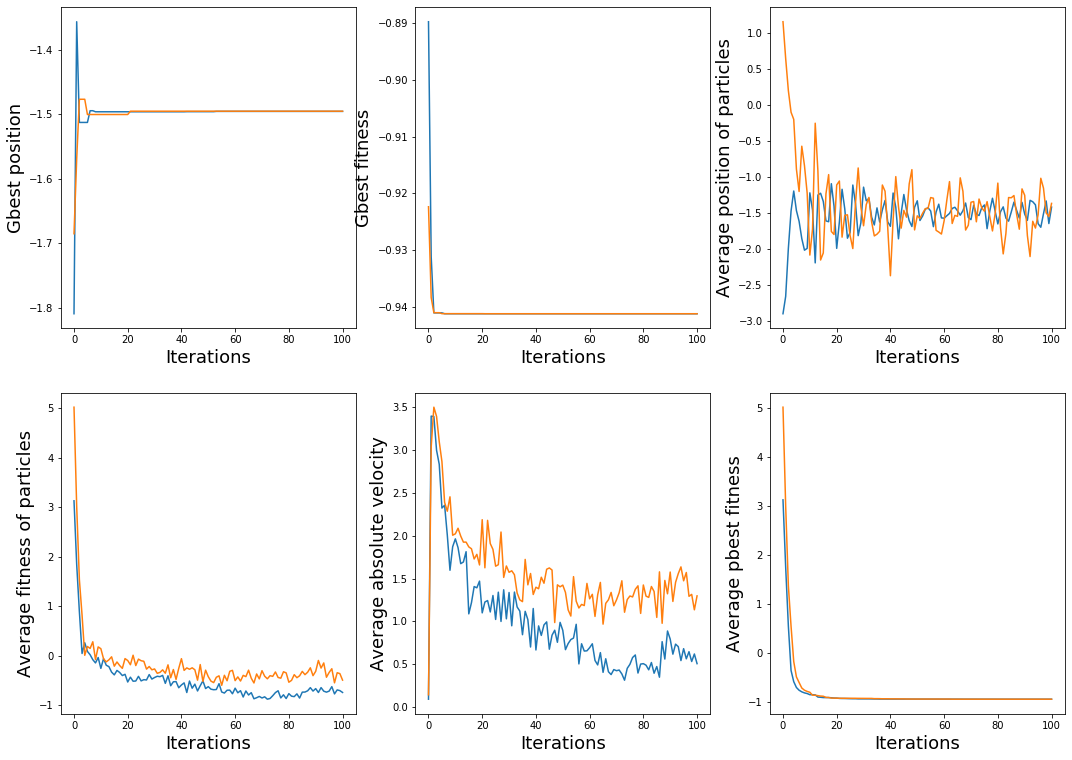

In [23]:
Nx = 25
w = 0.7
c1 = 2
c2 = 2

# cmap = ["tent", 0.49999]
# cmap = ["logistic", 4]
# cmap = ["lorenz", (10, 8.0/3, 28)]
chaosMan = chaosGenerator (cmap)

left = -20 
right = 20
intervalLength = right - left
vmax = intervalLength/10.0

xVan = intervalLength * np.random.rand(Nx, 1) - intervalLength/2
vVan = intervalLength/100.0 * np.random.rand(Nx, 1) - intervalLength/(2*100)
xChaos = intervalLength * chaosMan.getChaosPoints (Nx) - intervalLength/2
vChaos = intervalLength/100.0 * chaosMan.getChaosPoints (Nx) - intervalLength/(2*100)
pbestVan = xVan
pbestChaos = xChaos

numIter = 100
gbestVan = min (xVan , key = lambda x : obj(x))
gbestChaos = min (xChaos , key = lambda x : obj(x))

################################################################################################
# Plot 1 list -----------------> Gbest point per iteration
gbvCache = [gbestVan]
gbcCache = [gbestChaos]

# Plot 2 list -----------------> Gbest point objective value per iteration
gbvoCache = [obj(gbestVan)]
gbcoCache = [obj(gbestChaos)]

# Plot 3 list -----------------> Average of points 
xavgvCache = [np.average (xVan)]
xavgcCache = [np.average (xChaos)]

# Plot 4 list -----------------> Average of fitness
xoavgvCache = [np.average (obj(xVan))]
xoavgcCache = [np.average (obj(xChaos))]

# Plot 5 list -----------------> Average of absolute velocity
vavgvCache = [np.average (abs(vVan))]
vavgcCache = [np.average (abs(vChaos))]

# Plot 6 list -----------------> Average of pbest fitness
pbavgvCache = [np.average (obj(pbestVan))]
pbavgcCache = [np.average (obj(pbestChaos))]
################################################################################################

# Vanilla particles history
xvanCache = [xVan]

# Chaotic particles history
xchaosCache = [xChaos]

################################################################################################
for i in range (0, numIter) :
    r1 = np.random.rand (Nx, 1)
    r2 = np.random.rand (Nx, 1)
    r1c = chaosMan.getChaosPoints (Nx)
    r2c = chaosMan.getChaosPoints (Nx)
    
    vVan = w*vVan + c1*r1*(pbestVan - xVan) + c2*r2*(gbestVan - xVan)
    vabsVan = np.abs (vVan)
    vanClip = np.ones (shape = vVan.shape)
    vanClip[vabsVan > vmax] = vmax/vabsVan[vabsVan > vmax]
    vVan = vVan * vanClip
    xVan = xVan + vVan

    vChaos = w*vChaos + c1*r1c*(pbestChaos - xChaos) + c2*r2c*(gbestChaos - xChaos)
    vabsChaos = np.abs (vChaos)
    chaosClip = np.ones (shape = vChaos.shape)
    chaosClip[vabsChaos > vmax] = vmax/vabsChaos[vabsChaos > vmax]
    vChaos = vChaos * chaosClip
    xChaos = xChaos + vChaos
    
    less = obj(xVan) < obj(pbestVan)
    pbestVan = less * xVan + np.invert (less) * pbestVan
    less = obj(xChaos) < obj(pbestChaos)
    pbestChaos = less * xChaos + np.invert (less) * pbestChaos
    
    ################################################################################################
    gbestVanNew = min (xVan , key = lambda x : obj(x))
    if (obj(gbestVanNew) < obj(gbestVan)) :
        gbestVan = gbestVanNew
        
    gbestChaosNew = min (xChaos , key = lambda x : obj(x))
    if (obj(gbestChaosNew) < obj(gbestChaos)) :
        gbestChaos = gbestChaosNew
    
    # Appending to list for plot 1
    gbvCache.append (gbestVan)
    gbcCache.append (gbestChaos)
    
    # Appending to list for plot 2
    gbvoCache.append (obj(gbestVan))
    gbcoCache.append (obj(gbestChaos))
    
    # Appending to list for plot 3
    xavgvCache.append (np.average (xVan))
    xavgcCache.append (np.average (xChaos))
    
    # Appending to list for plot 4
    xoavgvCache.append (np.average (obj(xVan)))
    xoavgcCache.append (np.average (obj(xChaos)))
    
    # Appending to list for plot 5
    vavgvCache.append (np.average (abs(vVan)))
    vavgcCache.append (np.average (abs(vChaos)))
    
    # Appending to list for plot 6
    pbavgvCache.append (np.average (obj(pbestVan)))
    pbavgcCache.append (np.average (obj(pbestChaos)))
    ################################################################################################
    
    # Vanilla particles history
    xvanCache.append(xVan)

    # Chaotic particles history
    xchaosCache.append(xChaos)
    
    ################################################################################################
    

plt.figure(figsize = (18, 13))

# Plot 1 ---> Global best position vs. Iterations 
plt.subplot (2,3,1)
plt.plot (np.arange (numIter + 1), gbvCache)
plt.plot (np.arange (numIter + 1), gbcCache)
plt.ylabel ('Gbest position', fontsize = 18)
plt.xlabel ('Iterations', fontsize = 18)

# Plot 2 ---> Global best fitness vs. Iterations 
plt.subplot (2,3,2)
plt.plot (np.arange (numIter + 1), gbvoCache)
plt.plot (np.arange (numIter + 1), gbcoCache)
plt.ylabel ('Gbest fitness', fontsize = 18)
plt.xlabel ('Iterations', fontsize = 18)

# Plot 3 ---> Average absolute velocity vs. Iterations 
plt.subplot (2,3,3)
plt.plot (np.arange (numIter + 1), xavgvCache)
plt.plot (np.arange (numIter + 1), xavgcCache)
plt.ylabel ('Average position of particles', fontsize = 18)
plt.xlabel ('Iterations', fontsize = 18)

# Plot 4 ---> Average fitness vs. Iterations 
plt.subplot (2,3,4)
plt.plot (np.arange (numIter + 1), xoavgvCache)
plt.plot (np.arange (numIter + 1), xoavgcCache)
plt.ylabel ('Average fitness of particles', fontsize = 18)
plt.xlabel ('Iterations', fontsize = 18)

# Plot 5 ---> Average absolute velocity vs. Iterations 
plt.subplot (2,3,5)
plt.plot (np.arange (numIter + 1), vavgvCache)
plt.plot (np.arange (numIter + 1), vavgcCache)
plt.ylabel ('Average absolute velocity', fontsize = 18)
plt.xlabel ('Iterations', fontsize = 18)

# Plot 6 ---> Average pbest fitness vs. Iterations 
plt.subplot (2,3,6)
plt.plot (np.arange (numIter + 1), pbavgvCache)
plt.plot (np.arange (numIter + 1), pbavgcCache)
plt.ylabel ('Average pbest fitness', fontsize = 18)
plt.xlabel ('Iterations', fontsize = 18)

plt.show ()

# Final Particle Distribution

Vanilla correct for gbestVan = [-1.49592489]
Chaos correct for gbestChaos = [-1.49561363]
Same gbest
cntVan = 12
cntChaos = 3
Vanilla Final Average fitness = -0.7445446405866182
Chaotic Final Average fitness = -0.49542981775371503


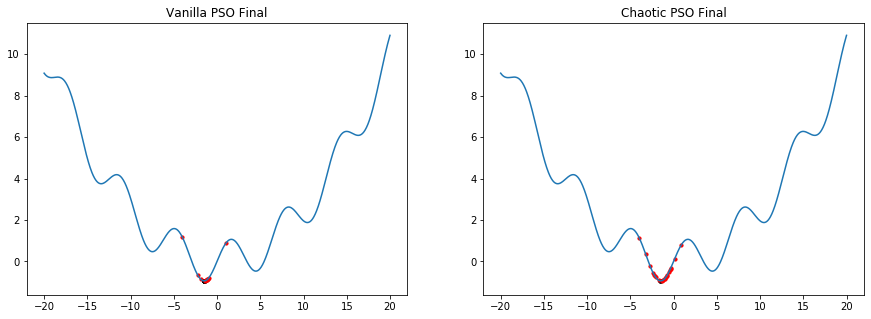

In [24]:
globMinVan = approx (xVan, gbestVan, 0.1, 0)
cntVan = sum (globMinVan)[0]
corrVan = xVan[globMinVan]
otherVan = xVan[np.invert(globMinVan)]
otherVanDer = np.array (list (zip (otherVan, objDer(otherVan))))

globMinChaos = approx (xChaos, gbestChaos, 0.1, 0)
cntChaos = sum (globMinChaos)[0]
corrChaos = xChaos[globMinChaos]
otherChaos = xChaos[np.invert(globMinChaos)]
otherChaosDer = np.array (list (zip (otherChaos, objDer(otherChaos))))

if approx (gbestVan, x_min, 0.1, 0)[0] :
    currMinVan = True
else :
    currMinVan = False
if approx (gbestChaos, x_min, 0.1, 0)[0] :
    currMinChaos = True
else :
    currMinChaos = False
    
import matplotlib.pyplot as plt
dotsize = 10

print ("Vanilla correct for gbestVan = " + str(gbestVan))
print ("Chaos correct for gbestChaos = " + str(gbestChaos))
if approx(gbestVan, gbestChaos, 0.1, 0) :
    pass
    print ("Same gbest")
else :
    pass
    print ("Different gbest f(" + str(gbestVan[0]) +") = " +str(obj(gbestVan)) + ", f(" + str(gbestChaos[0]) +") =" +str(obj(gbestChaos)))

print ("cntVan = " + str(cntVan))
print ("cntChaos = " + str(cntChaos))
print ("Vanilla Final Average fitness = " + str(xoavgvCache[-1]))
print ("Chaotic Final Average fitness = " + str(xoavgcCache[-1]))
    
xaxis = np.linspace (left, right, 1000)
plt.figure(figsize = (15, 5))
plt.subplot (1, 2, 1)
plt.title ("Vanilla PSO Final")
plt.plot (xaxis, obj(xaxis))
plt.scatter (corrVan, obj(corrVan), color='k', s=dotsize)
plt.scatter (otherVan, obj(otherVan), color='r', s=dotsize)

plt.subplot (1, 2, 2)
plt.title ("Chaotic PSO Final")
plt.plot (xaxis, obj(xaxis))
plt.scatter (corrChaos, obj(corrChaos), color='k', s=dotsize)
plt.scatter (otherChaos, obj(otherChaos), color='r', s=dotsize)

plt.show ()

# PSO Trajectory

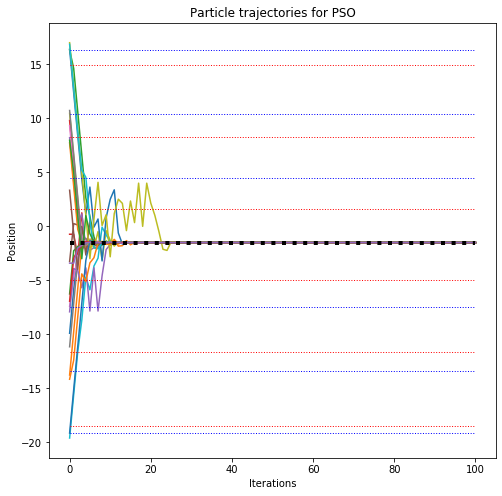

In [19]:
if type(xvanCache) == type([]) :
    xvanCache = np.array (xvanCache)

plt.figure(figsize = (8, 8))
i = 0
while i < Nx :
    plt.plot (np.arange (numIter + 1), xvanCache[:,i], label = "Point " + str(i+1))
    i = i + 1
    
plt.plot (np.arange (numIter + 1), x_min * np.ones (numIter+1), 'k:', linewidth=4)

for minpoint in minimas :
    plt.plot (np.arange (numIter + 1), minpoint * np.ones (numIter+1), 'b:',  linewidth=1)
    
for maxpoint in maximas :
    plt.plot (np.arange (numIter + 1), maxpoint * np.ones (numIter+1), 'r:',  linewidth=1)

plt.title ('Particle trajectories for PSO')
plt.xlabel ('Iterations')
plt.ylabel ('Position')
plt.show ()

# CPSO Trajectory

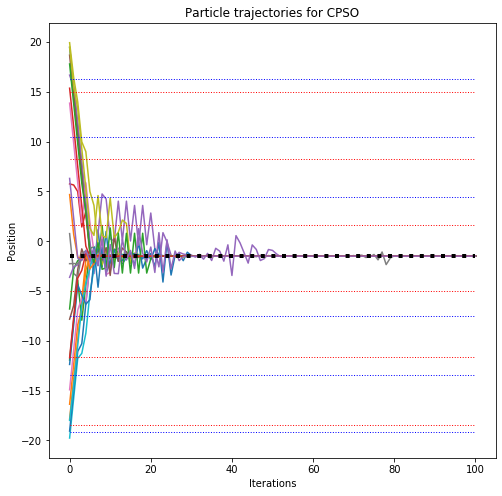

In [20]:
if type(xchaosCache) == type([]) :
    xchaosCache = np.array (xchaosCache)

plt.figure(figsize = (8, 8))
i = 0
while i < Nx :
    plt.plot (np.arange (numIter + 1), xchaosCache[:,i], label = "Point " + str(i+1))
    i = i + 1
    
plt.plot (np.arange (numIter + 1), x_min * np.ones (numIter+1), 'k:', linewidth=4)

for minpoint in minimas :
    plt.plot (np.arange (numIter + 1), minpoint * np.ones (numIter+1), 'b:',  linewidth=1)
    
for maxpoint in maximas :
    plt.plot (np.arange (numIter + 1), maxpoint * np.ones (numIter+1), 'r:',  linewidth=1)
    
plt.title ('Particle trajectories for CPSO')
plt.xlabel ('Iterations')
plt.ylabel ('Position')
plt.show ()